In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from config import *
from helper_functions import *
from model_functions import single_image_simple_model
import tensorflow as tf
import numbers
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import gc

In [2]:
imagefiles = [f for f in os.listdir(os.path.join(raw_data_folder, 'singleProc')) if os.path.isfile(os.path.join(raw_data_folder, 'singleProc', f)) and os.path.join(raw_data_folder, 'singleProc', f).split('.')[-1] == 'png']
keys_df = pd.read_csv(os.path.join(raw_data_folder, 'keyStrokesRaw.csv'))
keys_df.columns

Index(['q', 'w', 's', 'a', 'd', 'left_arrow', 'up_arrow', 'right_arrow',
       'down_arrow', 'time'],
      dtype='object')

In [3]:
images = []
labels = []
total_files = len(imagefiles)
for i, filename in enumerate(imagefiles):
    keys = np.array(get_key_pressed(int(filename.split('.')[0]), 100, keys_df))
    if float('nan') not in keys:
        img = cv2.imread(os.path.join(raw_data_folder, 'singleProc', filename), 1)[:,:,::-1]
        images.append(img)
        labels.append(keys[[1, 2, 5, 6, 7, 8]])
    print_progress(i+1, total_files, before_msg='Loading Data')
images = np.array(images)
labels = np.array(labels)
print('Images Shape:', images.shape)
print('Labels Shape:', labels.shape)

Loading Data 16346/16346 [##################################################]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Images Shape: (16346, 299, 299, 3)
Labels Shape: (16346, 6)


In [4]:
def aug_combo(img):
    """
    Apply random augmentations to the image
    img: ndarray
    """
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    combo = iaa.SomeOf((0,5),
                   [iaa.Add((-15, 15), per_channel=0.5),
                    iaa.LinearContrast((0.5, 2.0), per_channel=0.5),
#                     sometimes(iaa.ElasticTransformation(alpha=(0, img.shape[0]//5), sigma=img.shape[0]//50)),
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.02))),
                    iaa.Grayscale(alpha=(0.0, 0.3)),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Affine(shear=(0,10)),
                    iaa.OneOf([iaa.GaussianBlur((0, 3)),
                               iaa.AverageBlur(k=(2, 7)),
                               iaa.MedianBlur(k=(3, 11)),
                               iaa.MotionBlur(k=(5,10))]),
                    iaa.Multiply((0.8, 1.2), per_channel=0.5)], random_order=True)
    return (combo.augment_image(img))

In [5]:
def custom_data_generator(X, y, class_percent=None, batch_size=32, steps=1, train=True):
    while True:
        if train:
            images = []
            labels = []
            images_per_class = (np.array(class_percent)/100 * batch_size).round()
            if int(sum(images_per_class)) != batch_size:
                images_per_class[random.randint(0, len(class_percent)-1)] += 1
            for i, p in enumerate(images_per_class):
                if sum(y[:,i] == 1) != 0:
                    select_index = np.random.randint(0, sum(y[:,i] == 1), int(p))
                    images.extend(X[y[:,i] == 1][select_index])
                    labels.extend(y[y[:,i] == 1][select_index])
            images = np.array(list(map(aug_combo, images)))/255
            labels = np.array(labels)
            yield (images, labels)
        else:
            n = len(y)/steps
            if n - int(n) != 0:
                n+=1
            indexes = list(range(len(y)))
            index_batches = [indexes[i:i + int(n)] for i in range(0, len(indexes), int(n))]
            for ids in index_batches:
                images = X[ids]/255
                labels = y[ids]
                yield (images, labels)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.20, random_state=42)
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_valid Shape:', X_valid.shape)
print('y_valid Shape:', y_valid.shape)

del images, labels
gc.collect()

X_train Shape: (13076, 299, 299, 3)
y_train Shape: (13076, 6)
X_valid Shape: (3270, 299, 299, 3)
y_valid Shape: (3270, 6)


0

In [7]:
loss_model = keras.models.load_model('models/loss_fn_6_1')
for l in loss_model.layers: 
    l.trainable=False
    
def custom_lossfn(y_true, y_pred):
    return tf.math.reduce_sum(layers.ReLU()(loss_model([y_true, y_pred])))

def cLoss(y_true, y_pred):
    return tf.math.reduce_mean(layers.ReLU()(loss_model([y_true, y_pred])))

# def t2et(t):
#     return t.numpy()

# def cAcc(y_true, y_pred):
#     y_true = tf.py_function(func=t2et, inp=[y_true], Tout=tf.float32).numpy()
#     y_pred = tf.py_function(func=t2et, inp=[y_pred], Tout=tf.float32).numpy()
#     cp = 0
#     tp = 0
#     for i, row in enumerate((y_pred>0.5)/1):
#         for j, p in enumerate(row):
#             if p==1 or y_true[i][j] == 1:
#                 if p == y_true[i][j]:
#                     cp+=1
#                 tp+=1
#     return tf.constant(cp/tp)

In [8]:
def conv_layer(input_tensor, filters, kernel_size, strides, padding, activation, normalization, dropout_rate):
    x = layers.Conv2D(filters = filters, kernel_size = kernel_size, strides=strides,\
                      padding=padding, activation=activation)(input_tensor)
    if normalization == 'batch':
        x = layers.BatchNormalization()(x)
    if normalization == 'layer':
        x = layers.LayerNormalization()(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    return x

def dense_layer(input_tensor, units, activation, normalization, dropout_rate):
    x = layers.Dense(units=units, activation=activation)(input_tensor)
    if normalization == 'batch':
        x = layers.BatchNormalization()(x)
    if normalization == 'layer':
        x = layers.LayerNormalization()(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    return x

def single_image_simple_model(input_shape, classes, optimizer, conv_normalization = None, dense_normalization = None, \
                                 conv_dropout=0, dense_dropout=0):
    conv_layer_count = 5
    if isinstance(conv_dropout, numbers.Number):
        conv_dropout = [conv_dropout] * conv_layer_count

    dense_layer_count = 2
    if isinstance(dense_dropout, numbers.Number):
        dense_dropout = [dense_dropout] * dense_layer_count

    image_input = keras.Input(shape=input_shape)

    x = conv_layer(image_input, 24, (5,5), (2,2), 'valid', 'relu', conv_normalization, conv_dropout[0])
    x = conv_layer(x, 32, (5,5), (2,2), 'valid', 'relu', conv_normalization, conv_dropout[1])
    x = conv_layer(x, 48, (3,3), (2,2), 'valid', 'relu', conv_normalization, conv_dropout[2])
    x = conv_layer(x, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization, conv_dropout[3])
    x = conv_layer(x, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization, conv_dropout[4])

    x = layers.Flatten()(x)

    x = dense_layer(x, 128, 'relu', dense_normalization, dense_dropout[0])
    x = dense_layer(x, 64, 'relu', dense_normalization, dense_dropout[1])

    output = layers.Dense(units=classes, activation='sigmoid')(x)

    model = keras.Model(inputs=image_input, outputs=output, name="single_image_simple_model")
    model.compile(optimizer=optimizer, loss=custom_lossfn, metrics=[cLoss, 'accuracy'])
    return model

In [9]:
model = single_image_simple_model((299, 299, 3), 6, 'adam', 'batch', 'batch')
model.summary()

Model: "single_image_simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 24)      1824      
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 24)      96        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        19232     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 48)        13872     
_________________________________________________________________
batch_normalization_2 (Batch (None, 35, 3

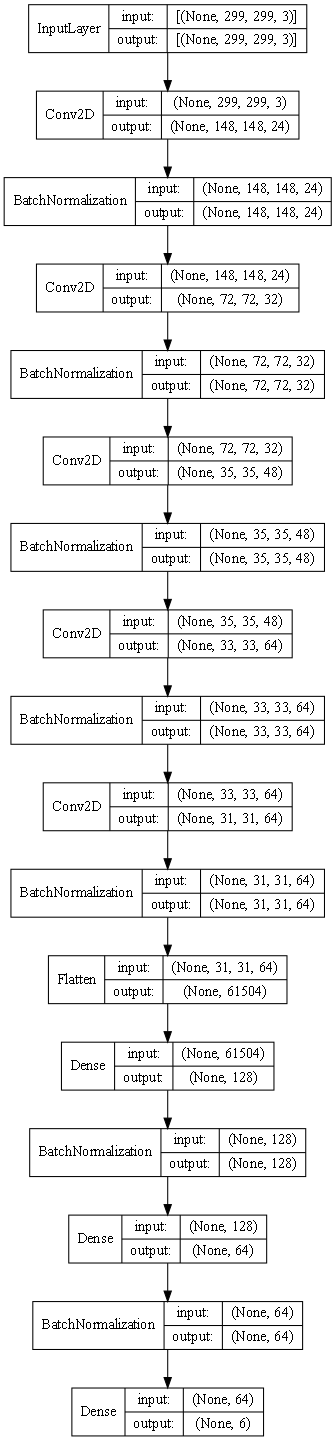

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir="TB", expand_nested=False, dpi=75)

In [11]:
# keys_percent = [15, 10, 0, 0, 30, 10, 25, 10]
keys_percent = [15, 10, 30, 10, 25, 10]
train_generator = custom_data_generator(X_train, y_train, keys_percent, 256)
valid_generator = custom_data_generator(X_valid, y_valid, steps=25, train=False)

history = model.fit(train_generator, epochs = 40, steps_per_epoch = 25, \
                    validation_data=valid_generator, validation_steps=25)

Epoch 1/25
100/100 [==============================] - 484s 5s/step - loss: 61.0352 - cLoss: 0.4768 - accuracy: 0.6212 - val_loss: nan - val_cLoss: nan - val_accuracy: 0.3192
Epoch 2/25
100/100 [==============================] - 469s 5s/step - loss: 31.4496 - cLoss: 0.2457 - accuracy: 0.8036 - val_loss: nan - val_cLoss: nan - val_accuracy: 0.3704
Epoch 3/25
100/100 [==============================] - 465s 5s/step - loss: 22.5835 - cLoss: 0.1764 - accuracy: 0.8105 - val_loss: nan - val_cLoss: nan - val_accuracy: 0.3418
Epoch 4/25
100/100 [==============================] - 471s 5s/step - loss: 7.6503 - cLoss: 0.0598 - accuracy: 0.7671 - val_loss: nan - val_cLoss: nan - val_accuracy: 0.3214
Epoch 5/25
100/100 [==============================] - 463s 5s/step - loss: 2.0184 - cLoss: 0.0158 - accuracy: 0.7504 - val_loss: nan - val_cLoss: nan - val_accuracy: 0.3105
Epoch 6/25
100/100 [==============================] - 472s 5s/step - loss: 1.1036 - cLoss: 0.0086 - accuracy: 0.7416 - val_loss: nan

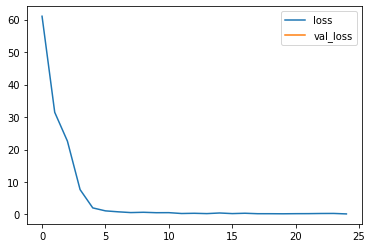

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

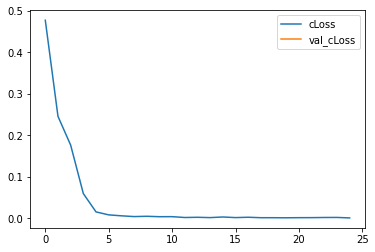

In [13]:
plt.plot(history.history['cLoss'], label='cLoss')
plt.plot(history.history['val_cLoss'], label='val_cLoss')
plt.legend()

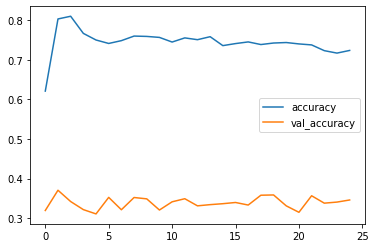

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [15]:
model.save('models/test_baseline_model_4')

INFO:tensorflow:Assets written to: models/test_baseline_model_4\assets
